# Urban Sound Multiclass Classifier
### ML1020 - Machine Learning at Scale

## Data Analysis

Let's load the train data and explore available classes and sample distirubtion between the classes. note: the test data is not labled thus it is useless for the training purpose. We have no choice but employ the train dataset to train and validate the model.

### Sound Classes

In [17]:
# improt required lbraries
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# define the path relative to the notebook source
# expected data structure
# -----------------------------------------------
# project root
# src
#   main.ipynb
# data
#   original
#     train
#       samples
#         *.wav
#       train.csv
#     test
#       samples
#         *.wav
#       test.csv
TRAIN_DATA_PATH = "../data/original/train"
TRAIN_FILE = "train.csv"
# Read the train data file 
data = pd.read_csv("{0}/{1}".format(TRAIN_DATA_PATH,TRAIN_FILE),sep = ',')

In [18]:
data.head(10)

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark
5,6,children_playing
6,10,street_music
7,11,drilling
8,12,gun_shot
9,15,dog_bark


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5435 entries, 0 to 5434
Data columns (total 2 columns):
ID       5435 non-null int64
Class    5435 non-null object
dtypes: int64(1), object(1)
memory usage: 85.0+ KB


Let's examine what classes are available

In [21]:
classes = data.Class.unique()
classes

array(['siren', 'street_music', 'drilling', 'dog_bark',
       'children_playing', 'gun_shot', 'engine_idling', 'air_conditioner',
       'jackhammer', 'car_horn'], dtype=object)

In [22]:
print("Number of classes: {0}".format(len(classes)))

Number of classes: 10


As per the output above the dataset comprises ten urban sound classes. It is time to take a look at the class population.

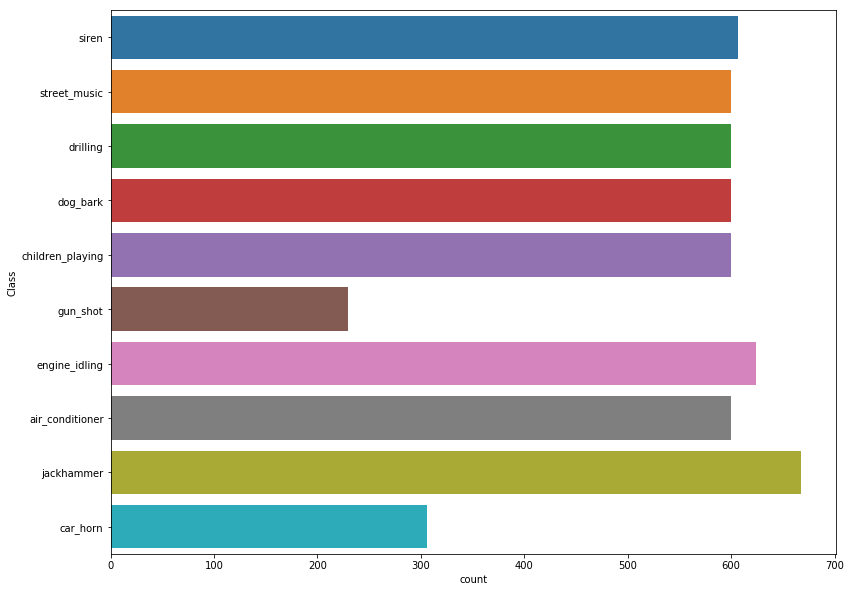

In [60]:
classDistribution = data.groupby(['Class']).count().reset_index().rename(columns={'ID':'Count'})
plt.figure(figsize=(13,10))
p = sns.countplot(data=data,y='Class')


`Gun Shot` and `Car Horn` categories are underpopulated. We could: 

* digitize and upsample these categories
* downsample all categories
* add more labeled observations to the smaller categories
* leave as is hoping that the categories with the smaller population stil have enough to train the network

Let's leave the data intact. If during the training we realize that the scarsly popluated categories are not detected well we will take action